## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Define the filepath

In [2]:
image_path = "DATA/"
image_directories = os.listdir(image_path)

## Loop and list the image folders

In [3]:
total_images = 0
for directory in image_directories:
    files = list(os.listdir(image_path + directory))
    print(f"{directory} folder has {str(len(files))} images")
    total_images = total_images + len(files)
print(f"Total image in the folders is {str(total_images)} images")

Golf folder has 160 images
hyundai tucson folder has 128 images
megane folder has 280 images
octavia folder has 156 images
picanto folder has 178 images
toyota corolla folder has 150 images
volkswagen tiguan folder has 184 images
Total image in the folders is 1236 images


## Define parameters

In [4]:
image_size =(224, 224)
batch_size = 32
seed = 123

## Load training and validation sets

In [5]:
train_set = tf.keras.utils.image_dataset_from_directory(
    image_path,
    seed=seed,
    batch_size=batch_size,
    image_size=image_size,
    label_mode='int',
    shuffle=True,
    subset='training',
    validation_split=0.2
)

Found 1236 files belonging to 7 classes.
Using 989 files for training.


In [6]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    image_path,
    seed=seed,
    batch_size=batch_size,
    image_size=image_size,
    label_mode='int',
    subset='validation',
    validation_split=0.2
)

Found 1236 files belonging to 7 classes.
Using 247 files for validation.


## Check label type

In [7]:
for images, labels in train_set.take(1):
    if labels.dtype == tf.float32 or labels.dtype == tf.float64:
        print("Labels are of type float")
    else:
        print("Labels are not of type float")
    break 

Labels are not of type float


In [8]:
# Convert the labels to integer type
# labels = tf.cast(labels, tf.int32)
unique_labels = np.unique(labels)
print(unique_labels)


[0 1 2 3 4 5 6]


## Display class names

In [9]:
cat_images =np.array(train_set.class_names)
cat_images

array(['Golf', 'hyundai tucson', 'megane', 'octavia', 'picanto',
       'toyota corolla', 'volkswagen tiguan'], dtype='<U17')

## Configure dataset for performance

In [10]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# validation_set = validation_set.cache().prefetch(buffer_size = AUTOTUNE)

## Compute class weight

In [11]:
# Initialize a dictionary to hold the class counts
class_counts = {i: 0 for i in range(7)}  

# Count the number of samples per class in the training set
for images, labels in train_set:
    labels = labels.numpy().flatten()  
    for label in labels:
        class_counts[int(label)] += 1

# Collect all labels from the training set
all_labels = []
for _, labels in train_set:
    all_labels.extend(labels.numpy().flatten().tolist())  

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weight_dict = dict(enumerate(class_weights))


# Print class weights for verification
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0868131868131867, 1: 1.2728442728442728, 2: 0.6727891156462585, 3: 1.1394009216589862, 4: 1.0312825860271115, 5: 1.1394009216589862, 6: 0.9234360410831}


## Visualize images from train-set

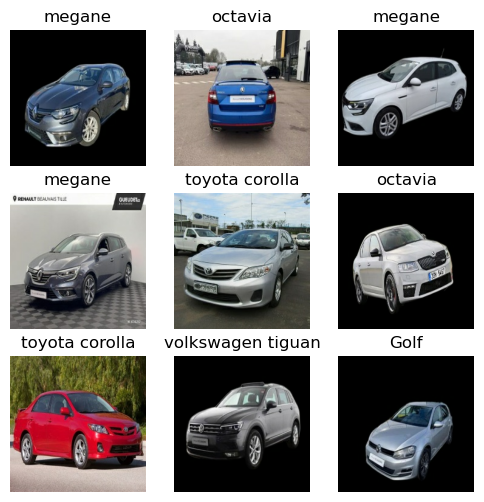

In [12]:
plt.figure(figsize=(6, 6))
for images, labels in train_set.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        if len(labels[i].shape) > 0:  
            label_index = int(np.argmax(labels[i].numpy()))
        else:  # Scalar case
            label_index = labels[i].numpy().item()

        # Ensure the label index is within bounds of cat_images
        if 0 <= label_index < len(cat_images):
            plt.title(cat_images[label_index])
        else:
            plt.title("Unknown")
        
        plt.axis('off')
plt.show()


## Set up the Model with ResNet50

In [13]:
# Define the input layer with the shape of input image
input_shape =(224, 224, 3)
input_layer = Input(shape=input_shape)

# Apply data augmentation
x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(input_layer)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)(x)
x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.3)(x)
x = tf.keras.layers.experimental.preprocessing.RandomContrast(0.3)(x)
x = tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)(x)

# Preprocess the input for Resnet50
x = tf.keras.applications.resnet50.preprocess_input(x)

# Load the ResNet model, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# freeze the base model
base_model.trainable = True

# Add ResNet base model
x = base_model(x)

# Add custom layers on top
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)

output_layer = Dense(7, activation='softmax')(x)

## Define the model

In [14]:
model = Model(inputs = input_layer, outputs = output_layer)

## Compile the model

In [15]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
metric = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metric)


## Print the model summary

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0     


## Apply Early Stopping and Learning Rate Reduction

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

## Fit the model for training

In [25]:
history = model.fit(
    train_set,
    validation_data = validation_set,
    class_weight = class_weight_dict,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15


31/31 [==============================] - 693s 21s/step - loss: 5.0306 - accuracy: 0.7836 - val_loss: 5.5202 - val_accuracy: 0.5870 - lr: 1.0000e-05
Epoch 2/15
31/31 [==============================] - 736s 24s/step - loss: 4.9099 - accuracy: 0.8180 - val_loss: 5.4217 - val_accuracy: 0.6356 - lr: 1.0000e-05
Epoch 3/15
31/31 [==============================] - 733s 24s/step - loss: 4.8311 - accuracy: 0.8423 - val_loss: 5.6262 - val_accuracy: 0.5506 - lr: 1.0000e-05
Epoch 4/15
31/31 [==============================] - 771s 25s/step - loss: 4.7635 - accuracy: 0.8716 - val_loss: 5.8443 - val_accuracy: 0.5061 - lr: 1.0000e-05
Epoch 5/15
31/31 [==============================] - 732s 24s/step - loss: 4.6865 - accuracy: 0.8928 - val_loss: 5.7554 - val_accuracy: 0.5304 - lr: 1.0000e-05
Epoch 6/15
31/31 [==============================] - 742s 24s/step - loss: 4.6062 - accuracy: 0.9221 - val_loss: 5.5941 - val_accuracy: 0.5385 - lr: 1.0000e-05
Epoch 7/15
31/31 [==============================] - 693s 

In [ ]:
model.save("Car.net5")